<a href="https://colab.research.google.com/github/pmnerfed/capstone_option_trading/blob/main/Review/Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long/Short Term Trading Strategies

In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")



In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [3]:
try:
    from get_all_tickers import get_tickers as gt
except ModuleNotFoundError:
    !pip install get-all-tickers
    from get_all_tickers import get_tickers as gt

from get_all_tickers.get_tickers import SectorConstants

  Preparing metadata (setup.py) ... done
  Created wheel for get-all-tickers: filename=get_all_tickers-1.8-py3-none-any.whl size=4230 sha256=fc0b34a931257ed1f86ed31c88732806d946e5f380fabc4ee4ecfdaf643d05d4
  Stored in directory: /root/.cache/pip/wheels/ca/d0/7d/7cbb7c19dc3b20b205bff412d6db0d81180ceceb07bd9d4ba8
Successfully built get-all-tickers


## Gathering the data

For our analysis we are using 10 technology companies.

| Ticker | Company Name                             |
|--------|------------------------------------------|
| AAPL   | Apple Inc.                                |
| ADBE   | Adobe Inc.                                |
| ORCL   | Oracle Corporation                        |
| EBAY   | eBay Inc.                                 |
| MSFT   | Microsoft Corporation                     |
| QCOM   | Qualcomm Incorporated                    |
| HPQ    | HP Inc.                                   |
| JNPR   | Juniper Networks, Inc.                    |
| AMD    | Advanced Micro Devices, Inc.              |
| IBM    | International Business Machines Corporation|
| SPY    | SPDR S&P 500 ETF Trust                    |

In [4]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%%**********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2020-12-24,131.970001,499.859985,91.809998,50.119999,24.260000,119.206497,22.400000,222.750000,64.959999,148.789993,369.000000
2020-12-28,136.690002,498.950012,91.599998,50.240002,24.270000,119.330788,22.559999,224.960007,64.870003,147.740005,372.170013
2020-12-29,134.869995,502.109985,90.620003,50.860001,24.049999,118.355644,22.190001,224.149994,64.459999,148.490005,371.459991
2020-12-30,133.720001,497.450012,92.290001,50.549999,24.320000,118.871895,22.200001,221.679993,64.400002,149.949997,371.989990
2020-12-31,132.690002,500.119995,91.709999,50.250000,24.590000,120.344170,22.510000,222.419998,64.690002,152.339996,373.880005


## Traditional Model

### Finding cointegrated Pairs

In [5]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return score_matrix, pvalue_matrix, pairs

[('ADBE', 'MSFT', 0.02081478537252975), ('EBAY', 'IBM', 0.02253077551368095), ('EBAY', 'ORCL', 0.032897950499253995), ('IBM', 'ORCL', 0.0019626127372477952), ('IBM', 'SPY', 0.0009854049357312063), ('ORCL', 'SPY', 0.00011442648552332336)]


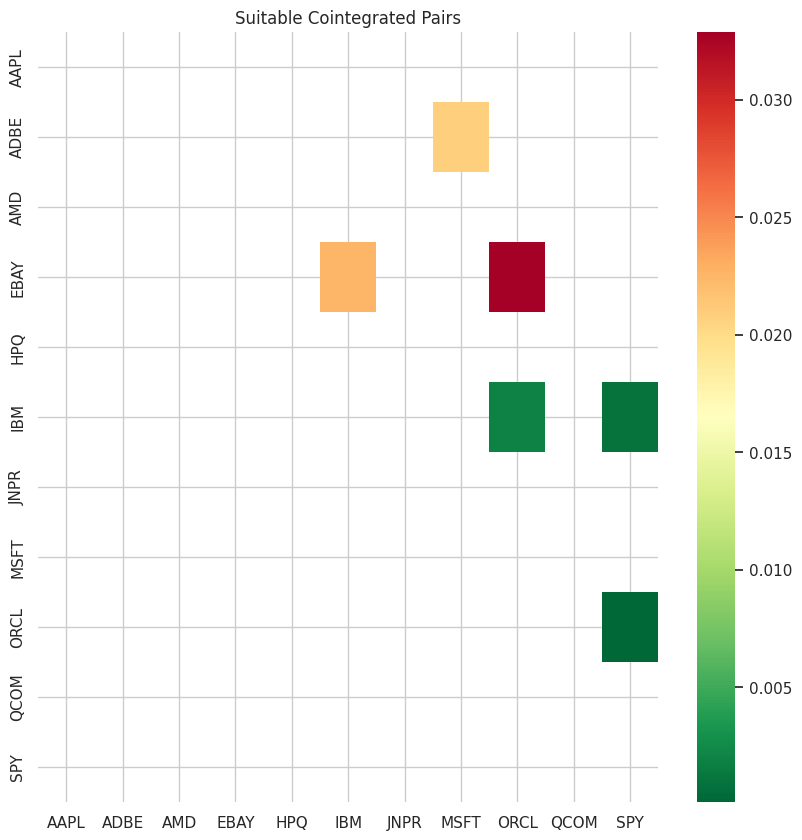

In [6]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
plt.title("Suitable Cointegrated Pairs")
print(pairs)

Lets look at pair trading for of the pairs (IBM, ORCL).

In [7]:
S1 = df['IBM']
S2 = df['ORCL']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0019626127372477952

### Calculating the spread across the first pair

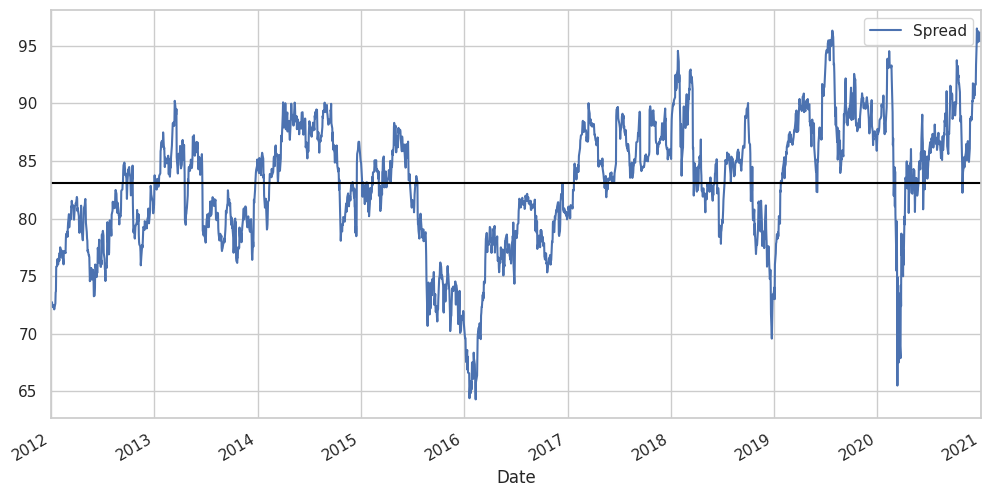

In [8]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['IBM']
b = results.params['IBM']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2012-01-01', '2021-01-01')
plt.legend(['Spread']);

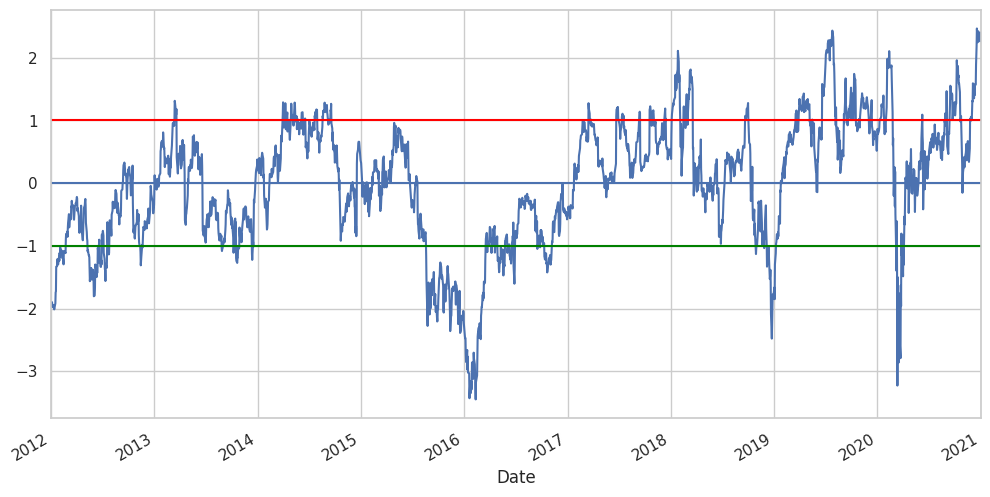

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(spread).plot(figsize=(12,6))
plt.axhline(zscore(spread).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2012-01-01', '2021-01-01')

plt.show()

### Trading Signals

In [10]:
ratios = df['IBM'] / df['ORCL']
print(len(ratios) * .70 )

1585.5


In [11]:
train = ratios[:1585]
test = ratios[1585:]

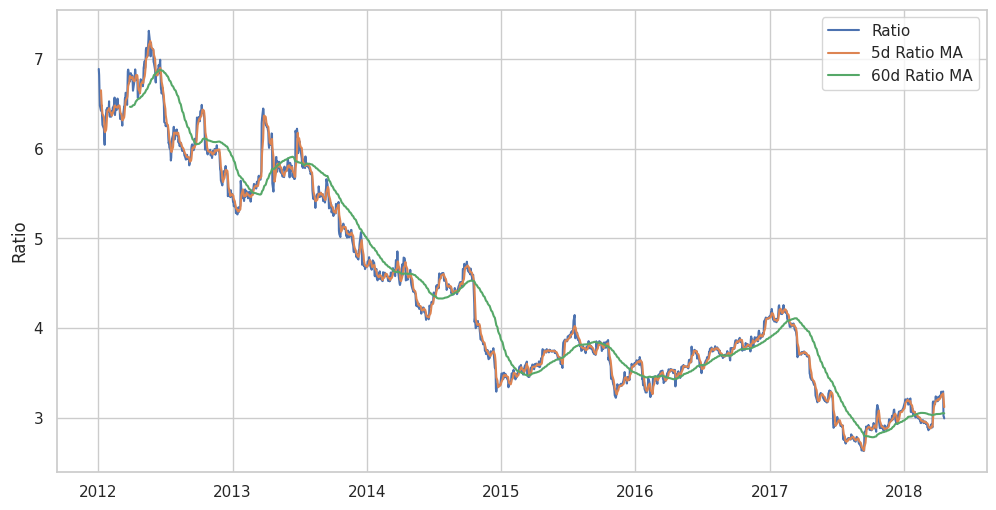

In [12]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

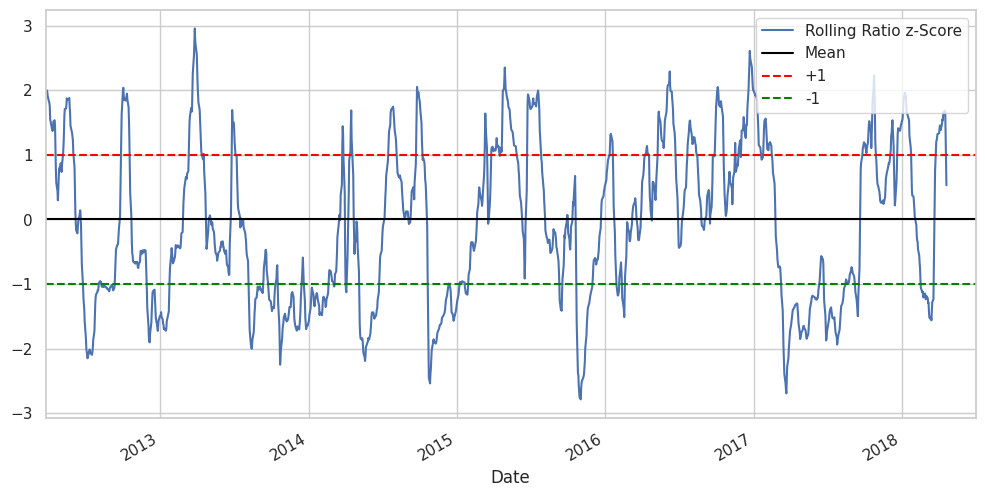

In [13]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2012-03-25', '2018-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

As we know the process tobe mean reverting i.e. if it goes beyond 1 standard deviation it will tend toward the mean. Using this information we can create following trading signals:
- Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
- Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

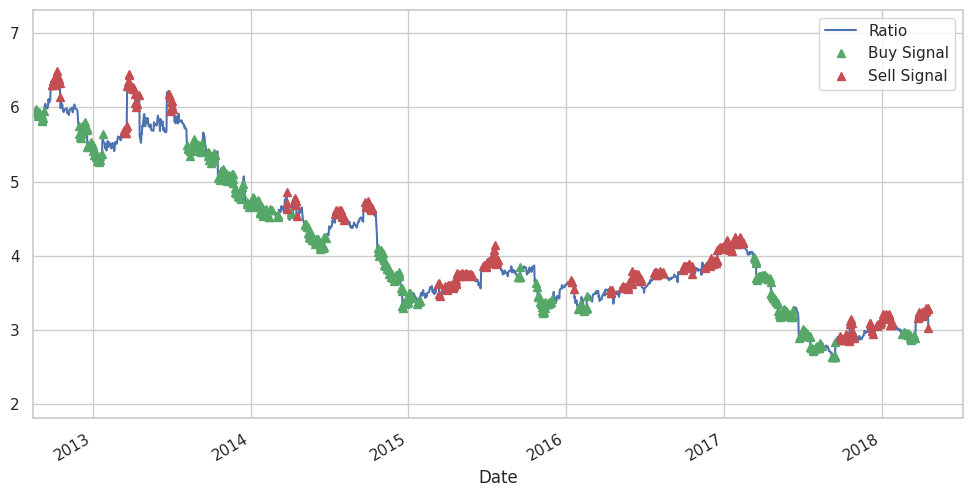

In [14]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2012-08-15','2018-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

<Axes: xlabel='Date'>

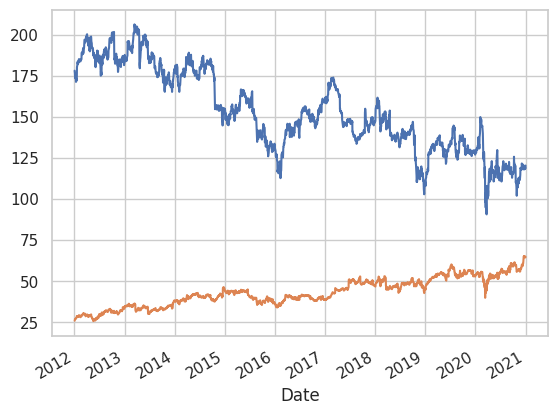

In [15]:
S1.plot()
S2.plot()

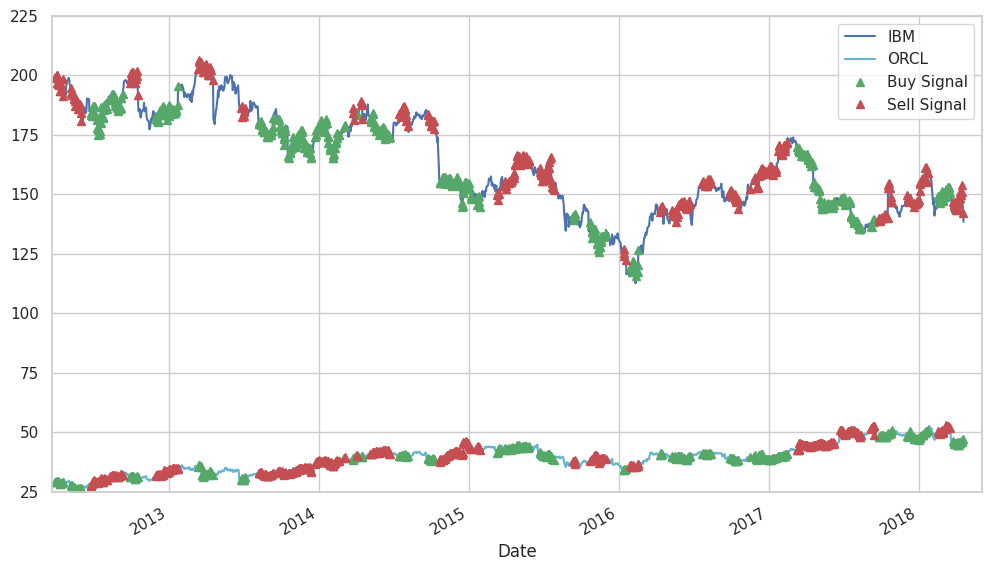

In [16]:
plt.figure(figsize=(12,7))
S1 = df['IBM'].iloc[:1585]
S2 = df['ORCL'].iloc[:1585]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 225)
plt.xlim('2012-03-22', '2018-06-04')

plt.legend(['IBM', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()

In [17]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [18]:
trade(df['IBM'].iloc[1585:], df['ORCL'].iloc[1585:], 60, 5)


1582.332371853834

## Improving Pair selection

We will try using SVM and Random forest methods to find contegrated pairs.

We will look at a lot more stock tickers to test the effectiveness of the pair selection algorithm.

The final check would be that the process should be stationary.

#### Getting data

In [19]:
import requests
import pandas as pd

def get_top_n_tickers(n):
    headers = {
        'authority': 'api.nasdaq.com',
        'accept': 'application/json, text/plain, */*',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
        'origin': 'https://www.nasdaq.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://www.nasdaq.com/',
        'accept-language': 'en-US,en;q=0.9',
    }

    params = (
        ('tableonly', 'true'),
        ('limit', '25'),
        ('offset', '0'),
        ('download', 'true'),
        ('exchange', 'nasdaq')
    )

    r = requests.get('https://api.nasdaq.com/api/screener/stocks', headers=headers, params=params)
    data = r.json()['data']
    df = pd.DataFrame(data['rows'], columns=data['headers'])
    df = df.dropna(subset={'marketCap'})
    df = df[df.sector == "Technology"]

    def cust_filter(mkt_cap):
            if 'M' in mkt_cap:
                return float(mkt_cap[1:-1])
            elif 'B' in mkt_cap:
                return float(mkt_cap[1:-1]) * 1000
            elif mkt_cap == '':
                return 0
            else:
                return float(mkt_cap[1:]) / 1e6

    df['marketCap'] = df['marketCap'].apply(cust_filter)

    df = df.sort_values('marketCap', ascending=False)[:n].reset_index()
    display(df[["symbol", 'name']])
    return df.symbol.to_list()

In [20]:
tickers_tech = get_top_n_tickers(50)

,symbol,name
0,GOOG,Alphabet Inc. Class C Capital Stock
1,GOOGL,Alphabet Inc. Class A Common Stock
2,AAPL,Apple Inc. Common Stock
3,META,Meta Platforms Inc. Class A Common Stock
4,NVDA,NVIDIA Corporation Common Stock
5,ASML,ASML Holding N.V. New York Registry Shares
6,QCOM,QUALCOMM Incorporated Common Stock
7,INTC,Intel Corporation Common Stock
8,INTU,Intuit Inc. Common Stock
9,AMAT,Applied Materials Inc. Common Stock


In [21]:

tech_data = pdr.get_data_yahoo(tickers_tech, start, end)['Close']

[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['HOOD', 'GFS']: Exception("%ticker%: Data doesn't exist for startDate = 1325394000, endDate = 1609477200")


In [22]:
tech_data.dropna(axis=1, inplace=True)

In [23]:
tech_data.head()

Ticker,AAPL,ADBE,ADI,ADP,AMAT,AMD,ANSS,ASML,AVGO,CHKP,...,NTES,NVDA,NXPI,QCOM,SNPS,SSNC,STX,SWKS,TXN,VRSN
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,28.570000,36.029999,47.813873,10.70,5.48,57.389999,42.220001,28.950001,52.970001,...,9.026,3.5100,16.01,55.270000,26.990000,9.050,16.430000,16.820000,29.760000,35.820000
2012-01-04,14.765714,28.280001,35.980000,47.761192,10.76,5.46,56.400002,41.630001,28.450001,51.730000,...,9.036,3.5500,16.17,55.830002,26.490000,8.950,16.820000,16.780001,29.570000,35.820000
2012-01-05,14.929643,28.480000,36.139999,48.112377,10.83,5.46,57.299999,41.180000,28.490000,52.270000,...,9.062,3.6775,16.50,56.060001,26.850000,9.005,17.900000,17.280001,29.780001,35.740002
2012-01-06,15.085714,28.719999,35.900002,48.182617,11.01,5.43,56.939999,40.910000,28.309999,51.360001,...,8.856,3.6350,16.90,56.160000,26.870001,9.000,18.299999,17.150000,29.780001,35.400002
2012-01-09,15.061786,28.530001,36.599998,47.998245,11.34,5.59,56.680000,41.240002,30.219999,51.330002,...,8.416,3.6350,17.68,55.910000,27.040001,9.005,18.190001,17.809999,30.160000,35.020000


Now we have the closing prices for top 40 tech stocks and we can use these for our analysis.

In [24]:
X_train, X_test = np.split(tech_data, [int(.67 *len(tech_data))])

In [25]:
X_train

Ticker,AAPL,ADBE,ADI,ADP,AMAT,AMD,ANSS,ASML,AVGO,CHKP,...,NTES,NVDA,NXPI,QCOM,SNPS,SSNC,STX,SWKS,TXN,VRSN
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,28.570000,36.029999,47.813873,10.700000,5.48,57.389999,42.220001,28.950001,52.970001,...,9.026000,3.510000,16.010000,55.270000,26.990000,9.050000,16.430000,16.820000,29.760000,35.820000
2012-01-04,14.765714,28.280001,35.980000,47.761192,10.760000,5.46,56.400002,41.630001,28.450001,51.730000,...,9.036000,3.550000,16.170000,55.830002,26.490000,8.950000,16.820000,16.780001,29.570000,35.820000
2012-01-05,14.929643,28.480000,36.139999,48.112377,10.830000,5.46,57.299999,41.180000,28.490000,52.270000,...,9.062000,3.677500,16.500000,56.060001,26.850000,9.005000,17.900000,17.280001,29.780001,35.740002
2012-01-06,15.085714,28.719999,35.900002,48.182617,11.010000,5.43,56.939999,40.910000,28.309999,51.360001,...,8.856000,3.635000,16.900000,56.160000,26.870001,9.000000,18.299999,17.150000,29.780001,35.400002
2012-01-09,15.061786,28.530001,36.599998,47.998245,11.340000,5.59,56.680000,41.240002,30.219999,51.330002,...,8.416000,3.635000,17.680000,55.910000,27.040001,9.005000,18.190001,17.809999,30.160000,35.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-05,43.750000,185.339996,91.669998,118.300003,54.599998,11.88,152.449997,182.869995,271.619995,103.419998,...,68.853996,53.849998,118.050003,66.470001,88.930000,41.849998,42.939999,101.230003,109.120003,113.000000
2018-01-08,43.587502,185.039993,91.830002,117.940002,55.919998,12.28,153.710007,183.830002,272.269989,103.599998,...,68.954002,55.500000,118.279999,66.269997,89.760002,42.209999,46.000000,101.250000,109.639999,114.309998
2018-01-09,43.582500,186.699997,91.639999,118.760002,54.860001,11.82,155.139999,182.839996,268.500000,103.199997,...,67.809998,55.485001,118.449997,65.269997,89.690002,42.270000,46.389999,100.680000,110.389999,112.970001


In [94]:
X = X.T

## Clustering

we will try to use the clustering to detect similar pairs of stocks and test cointegration between each pair.

This would improve efficiency in detecting suitable pairs from a large number of stocks improving upon the brute force method of the traditional method.

<#####>

To use the clustering approach we need to generate some kind of distance matrix for all the stocks.

In [26]:
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import homogeneity_score
from sklearn.cluster import AgglomerativeClustering

In [27]:
try:
    from pyts.metrics import dtw, boss
    from pyts.transformation import BOSS
except:
    !pip install pyts
    from pyts.metrics import dtw, boss
    from pyts.transformation import BOSS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.3 MB/s eta 0:00:00


### Distance measurement for Clustering

<#####>

Talk about euclidean vs BOSS distance.

In [28]:
def create_dist_matrix(dataset, dist_func, **kwargs):
    distance_mat = np.zeros((len(dataset), len(dataset)))
    for i, j in itertools.product(range(len(dataset)),
                                  range(len(dataset))):
        distance_mat[i, j] = dist_func(dataset[i], dataset[j], **kwargs)
    return distance_mat

In [29]:
def plot_dendrogram(model, **kwargs):
    # function copied from sklearn:
    # plot_agglomerative_dendrogram.html
    #
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,
               color_threshold=sorted(model.distances_)[-2], **kwargs)

### Euclidean distance

In [30]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(tech_data)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(tech_data),columns = tech_data.columns, index = tech_data.index)
X = scaled_data
X.head()

Ticker,AAPL,ADBE,ADI,ADP,AMAT,AMD,ANSS,ASML,AVGO,CHKP,...,NTES,NVDA,NXPI,QCOM,SNPS,SSNC,STX,SWKS,TXN,VRSN
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,-0.987122,-1.021061,-1.354235,-1.380199,-1.221454,-0.518530,-1.013575,-1.160972,-1.336322,-1.379254,...,-1.243652,-0.800255,-1.918517,-0.768569,-0.975542,-1.565610,-2.507545,-1.632280,-1.260211,-1.144482
2012-01-04,-0.983893,-1.023391,-1.356066,-1.381574,-1.218067,-0.519504,-1.027058,-1.167442,-1.341113,-1.430230,...,-1.243230,-0.799043,-1.913813,-0.735974,-0.985520,-1.571581,-2.472765,-1.633435,-1.265558,-1.144482
2012-01-05,-0.977186,-1.021784,-1.350206,-1.372410,-1.214116,-0.519504,-1.014800,-1.172376,-1.340730,-1.408031,...,-1.242133,-0.795181,-1.904111,-0.722587,-0.978336,-1.568297,-2.376454,-1.618998,-1.259648,-1.145852
2012-01-06,-0.970801,-1.019857,-1.358996,-1.370577,-1.203954,-0.520964,-1.019703,-1.175337,-1.342454,-1.445441,...,-1.250828,-0.796468,-1.892351,-0.716766,-0.977936,-1.568596,-2.340783,-1.622751,-1.259648,-1.151672
2012-01-09,-0.971780,-1.021383,-1.333359,-1.375388,-1.185326,-0.513175,-1.023244,-1.171718,-1.324155,-1.446674,...,-1.269401,-0.796468,-1.869419,-0.731318,-0.974544,-1.568297,-2.350592,-1.603694,-1.248952,-1.158177


In [31]:
len(X)

2265

In [32]:
n_clusters = range(2, 20)

In [33]:
dist_mat_euc = create_dist_matrix(X.T.values, euclidean)


In [34]:
dist_mat_euc.shape

(37, 37)

<Axes: >

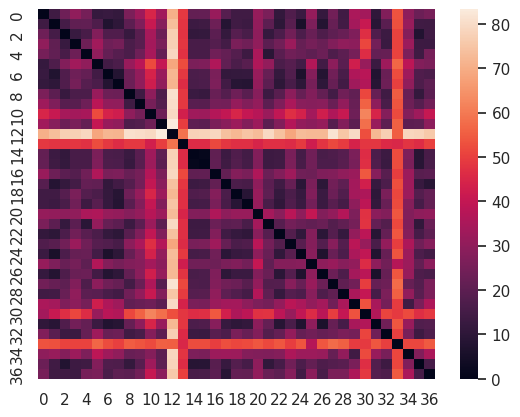

In [58]:
seaborn.heatmap(dist_mat_euc)

In [59]:
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [60]:
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator


In [61]:
sillhouettes = []
for k in n_clusters:
    # model = AgglomerativeClustering(compute_full_tree=True,
    #                                 compute_distances=True,
    #                                 n_clusters=k, affinity="precomputed",
    #                                 linkage="complete")
    # model.fit(X.T)
    model2 = AgglomerativeClustering(n_clusters=k).fit(dist_mat_euc)
    sillhouettes.append(silhouette_score(dist_mat_euc, model2.labels_))

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distanc

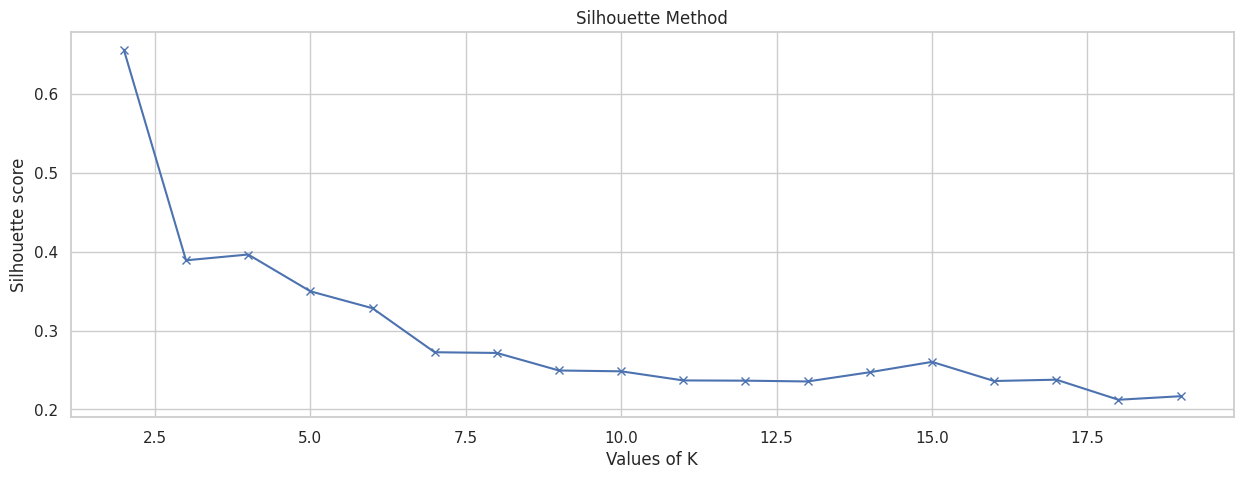

Suggested number of clusters:  3


In [62]:
#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(n_clusters, sillhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(n_clusters, sillhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


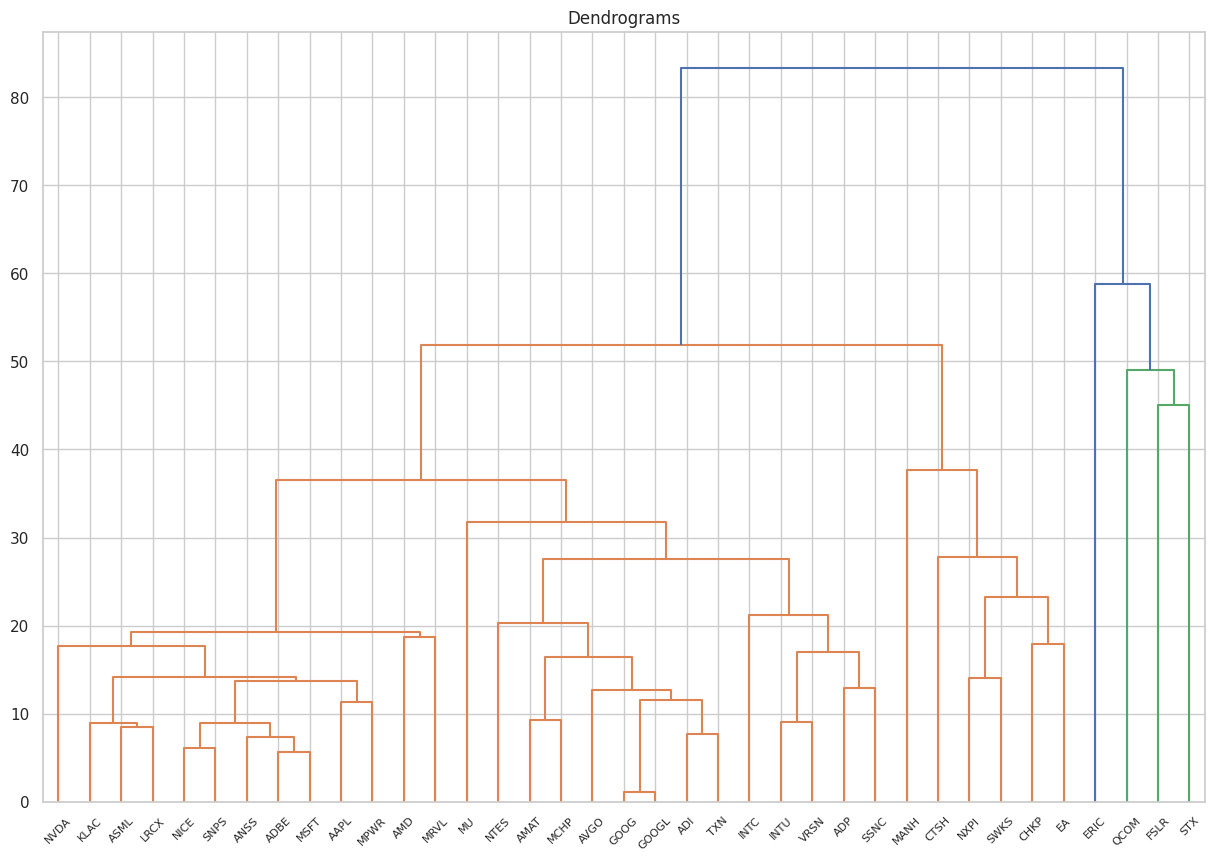

In [64]:
c=6
#Fit the model
hc = AgglomerativeClustering(compute_distances=True, n_clusters= c, affinity='precomputed', linkage='complete')
labels = hc.fit_predict(dist_mat_euc)

#Plot the results
plt.figure(figsize=(15, 10))
plt.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(X.T, method='ward'), labels=tech_data.columns)
plot_dendrogram(hc, labels=tech_data.columns)

In [ ]:
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import seaborn as sns

def plot_clusters(distMatrix, linkage=None):
    # define distance array as in linked answer
    distArray = ssd.squareform(distMatrix)

    # define linkage object
    distLinkage = hierarchy.linkage(distArray)

    # make clustermap
    sns.clustermap(distMatrix, row_linkage=distLinkage, col_linkage=distLinkage)

'complete'

In [65]:
def select_pairs(labels, dist_mat, threshold = 8):
    result = {value: [i for i, x in enumerate(labels) if x == value] for value in set(labels)}
    trading_pairs = []

    # get pairs
    for cluster, stocks in result.items():
        if len(stocks) >= 2:
            trading_pairs.extend(list(itertools.combinations(stocks, 2)))
    # filter pairs
    filtered = []
    l = 0
    for a, b in trading_pairs:
        l += dist_mat[a, b] < threshold
        if dist_mat[a, b] < threshold:
            filtered.append((a, b))
    print(l)
    return filtered

In [79]:
euc_pairs_num = select_pairs(labels, dist_mat_euc)

12


In [82]:
euc_pairs_num

[(1, 6),
 (1, 24),
 (1, 26),
 (2, 35),
 (6, 7),
 (6, 24),
 (6, 26),
 (6, 31),
 (14, 15),
 (24, 26),
 (24, 31),
 (26, 31)]

In [85]:
euc_pairs = []
for a, b, in euc_pairs_num:
    euc_pairs.append((tech_data.columns[a], tech_data.columns[b]))
euc_pairs

[('ADBE', 'ANSS'),
 ('ADBE', 'MSFT'),
 ('ADBE', 'NICE'),
 ('ADI', 'TXN'),
 ('ANSS', 'ASML'),
 ('ANSS', 'MSFT'),
 ('ANSS', 'NICE'),
 ('ANSS', 'SNPS'),
 ('GOOG', 'GOOGL'),
 ('MSFT', 'NICE'),
 ('MSFT', 'SNPS'),
 ('NICE', 'SNPS')]

### BOSS DISTANCE

In [68]:
dist_mat_boss = create_dist_matrix(BOSS(sparse=False, n_bins=3,
                                           word_size=3).fit_transform(X),
                                      boss)

In [69]:

model = AgglomerativeClustering(compute_full_tree=True,
                                    compute_distances=True,
                                    n_clusters=14, affinity="precomputed",
                                    linkage="complete")
cluster = model.fit_predict(dist_mat_boss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [72]:
cluster

array([11, 13,  7,  4, 10,  6,  3, 11,  1,  0,  0,  1,  9,  9, 10, 10,  0,
        3,  2,  3,  4,  7,  5,  2,  3,  0,  3,  1, 12,  0,  8,  5,  4,  9,
        0, 10,  3])

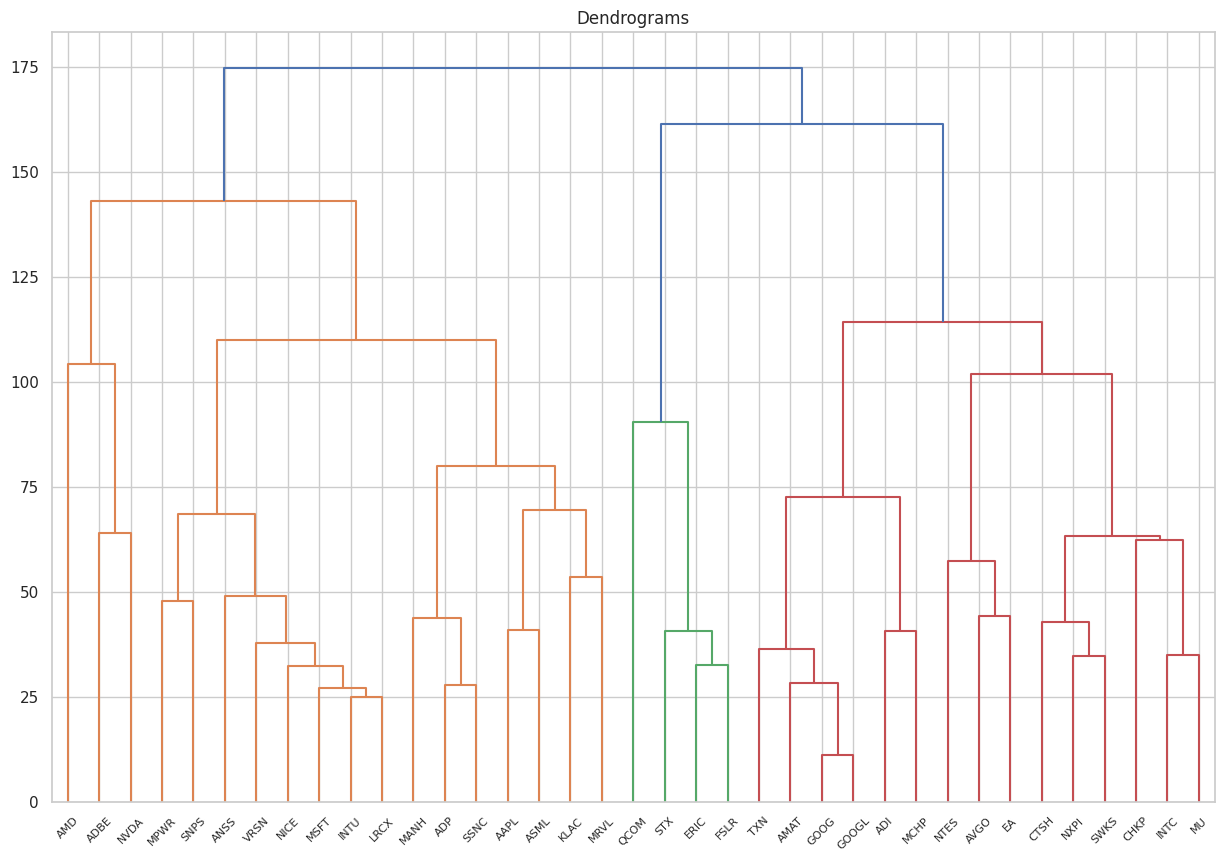

In [75]:
plt.figure(figsize=(15, 10))
plt.title("Dendrograms")
plot_dendrogram(model, labels=tech_data.columns)

In [86]:
boss_pairs_num = select_pairs(cluster, dist_mat_boss, threshold=32)

12


In [87]:
boss_pairs = []
for a, b, in boss_pairs_num:
    boss_pairs.append((tech_data.columns[a], tech_data.columns[b]))
boss_pairs

[('INTU', 'LRCX'),
 ('INTU', 'MSFT'),
 ('INTU', 'NICE'),
 ('INTU', 'VRSN'),
 ('LRCX', 'MSFT'),
 ('LRCX', 'VRSN'),
 ('MSFT', 'NICE'),
 ('ADP', 'SSNC'),
 ('AMAT', 'GOOG'),
 ('AMAT', 'GOOGL'),
 ('AMAT', 'TXN'),
 ('GOOG', 'GOOGL')]

### Compare normal distance and BOSS distance results

We control the threshold to generate similar number of pairs here. But we see vastly different pairs forming using the boss distance compared to the euclidian distance.

In [99]:
euc_pairs

[('ADBE', 'ANSS'),
 ('ADBE', 'MSFT'),
 ('ADBE', 'NICE'),
 ('ADI', 'TXN'),
 ('ANSS', 'ASML'),
 ('ANSS', 'MSFT'),
 ('ANSS', 'NICE'),
 ('ANSS', 'SNPS'),
 ('GOOG', 'GOOGL'),
 ('MSFT', 'NICE'),
 ('MSFT', 'SNPS'),
 ('NICE', 'SNPS')]

In [100]:
boss_pairs

[('INTU', 'LRCX'),
 ('INTU', 'MSFT'),
 ('INTU', 'NICE'),
 ('INTU', 'VRSN'),
 ('LRCX', 'MSFT'),
 ('LRCX', 'VRSN'),
 ('MSFT', 'NICE'),
 ('ADP', 'SSNC'),
 ('AMAT', 'GOOG'),
 ('AMAT', 'GOOGL'),
 ('AMAT', 'TXN'),
 ('GOOG', 'GOOGL')]

<#####> Create clusters using Agglomerative clustering



### Affinity Propagation

In [98]:
dist_mat_euc

array([[ 0.        , 13.7381482 , 23.62837454, ..., 29.88480293,
        22.82641062, 25.11806749],
       [13.7381482 ,  0.        , 14.99582397, ..., 31.39268822,
        14.21267049, 13.8738123 ],
       [23.62837454, 14.99582397,  0.        , ..., 27.85465383,
         7.72428569, 14.1716012 ],
       ...,
       [29.88480293, 31.39268822, 27.85465383, ...,  0.        ,
        27.20415997, 35.22923984],
       [22.82641062, 14.21267049,  7.72428569, ..., 27.20415997,
         0.        , 15.56316259],
       [25.11806749, 13.8738123 , 14.1716012 , ..., 35.22923984,
        15.56316259,  0.        ]])

In [111]:
from sklearn.cluster import AffinityPropagation

#Fit the model
af = AffinityPropagation(affinity="precomputed", preference=75)
af.fit(dist_mat_euc)

af.labels_
#Plot the results
# shc.dendograms(ap.labels_)

array([ 0,  1,  5,  5,  5,  2,  3,  4,  5,  5,  5,  5,  5,  6,  5,  5,  5,
        7,  8,  9, 10,  5, 11, 12, 13, 14, 15,  5, 16,  5, 17, 18,  5, 19,
        5,  5,  5])

In [115]:
cluster_centers_indices = af.cluster_centers_indices_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(X, labels, metric="sqeuclidean")
)

Estimated number of clusters: 20
Silhouette Coefficient: 0.455


In [127]:
ap_euc_pairs_num = select_pairs(af.labels_, dist_mat_euc, threshold=12.5)

13


In [128]:
ap_euc_pairs = []
for a, b, in ap_euc_pairs_num:
    ap_euc_pairs.append((tech_data.columns[a], tech_data.columns[b]))
ap_euc_pairs

[('ADI', 'ADP'),
 ('ADI', 'AVGO'),
 ('ADI', 'GOOG'),
 ('ADI', 'GOOGL'),
 ('ADI', 'MCHP'),
 ('ADI', 'TXN'),
 ('AMAT', 'MCHP'),
 ('AVGO', 'GOOGL'),
 ('AVGO', 'TXN'),
 ('GOOG', 'GOOGL'),
 ('GOOG', 'TXN'),
 ('GOOGL', 'TXN'),
 ('MCHP', 'TXN')]

### BOSS Distance

In [135]:
from sklearn.cluster import AffinityPropagation

#Fit the model
af = AffinityPropagation(affinity="precomputed", preference=130)
af.fit(dist_mat_boss)

af.labels_


array([ 0,  9,  2,  1,  9,  2,  9,  3,  9,  2,  2,  9,  2,  2,  2,  2,  4,
        9,  5,  9,  6,  2,  9,  7,  9,  2,  9,  9,  9,  8,  9,  9, 10,  2,
        2,  9,  9])

In [136]:
cluster_centers_indices = af.cluster_centers_indices_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(X, labels, metric="sqeuclidean")
)

Estimated number of clusters: 11
Silhouette Coefficient: 0.455


In [143]:
ap_boss_pairs_num = select_pairs(af.labels_, dist_mat_boss, threshold=35)

12


In [144]:
ap_boss_pairs = []
for a, b, in ap_boss_pairs_num:
    ap_boss_pairs.append((tech_data.columns[a], tech_data.columns[b]))
ap_boss_pairs

[('ERIC', 'FSLR'),
 ('GOOG', 'GOOGL'),
 ('AMAT', 'TXN'),
 ('INTU', 'LRCX'),
 ('INTU', 'MSFT'),
 ('INTU', 'NICE'),
 ('INTU', 'VRSN'),
 ('LRCX', 'MSFT'),
 ('LRCX', 'NICE'),
 ('LRCX', 'VRSN'),
 ('MSFT', 'NICE'),
 ('NICE', 'VRSN')]

#### Comparision

Now We will use the traditional trade function declared at the beginnining to calculate the trade profitability of each strategy.

In [156]:
from tabulate import tabulate

In [164]:
def profitability(pair_list):
    money = 0
    max = -1
    max_stock = ''
    for a, b in pair_list:
        trade_profit = trade(X_train[a], X_train[b], 60, 5)
        money+=trade_profit
        if trade_profit > max:
            max = trade_profit
            max_stock = (a, b)
    return money, max_stock

In [167]:
print(tabulate([["Profit with max profit pair", "Euclidean", "BOSS" ], ["Agglomerative Clustering", profitability(euc_pairs), profitability(boss_pairs)], ["Affinity Progression Clustering", profitability(ap_euc_pairs), profitability(ap_boss_pairs)]], headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════════════╤════════════════════════════════════════╤═══════════════════════════════════════╕
│ Profit with max profit pair     │ Euclidean                              │ BOSS                                  │
╞═════════════════════════════════╪════════════════════════════════════════╪═══════════════════════════════════════╡
│ Agglomerative Clustering        │ (15831.491292394187, ('ANSS', 'ASML')) │ (8161.842624612116, ('INTU', 'NICE')) │
├─────────────────────────────────┼────────────────────────────────────────┼───────────────────────────────────────┤
│ Affinity Progression Clustering │ (8509.512605863956, ('AVGO', 'TXN'))   │ (8049.286972595513, ('INTU', 'NICE')) │
╘═════════════════════════════════╧════════════════════════════════════════╧═══════════════════════════════════════╛


From Above We can see that Aggelomerative clustering with Euclidean distance vastly outperforms the other combinations of algorithem and distance.

### LSTM

- We will select a pair from above
- generate features like moving average and volume data
- create a LSTM model
- train the LSTM model

Lets select the  pairs generated from agglomerative clustering using Euclidean distance for generatng our model

In [218]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

In [219]:
pair = ("ANSS", "ASML")

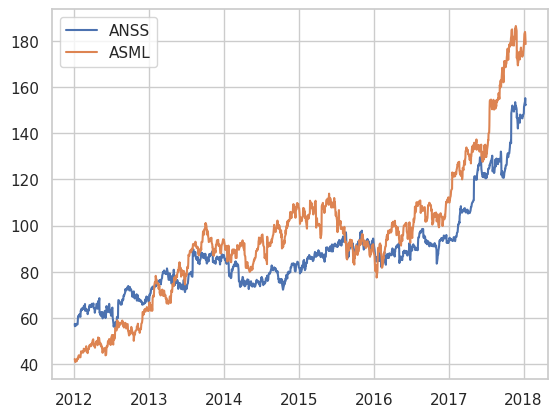

In [220]:
plt.plot(X_train["ANSS"],label='ANSS')
plt.plot(X_train["ASML"],label='ASML')
plt.legend()
plt.show();

In [221]:
X = X_train["ANSS"][:100]
Y = X_train["ASML"][:100]

In [222]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Activation, Dense, Dropout
import keras.callbacks

In [223]:
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1))
    data = scaler.fit_transform(data)

    return data

data = prep_feature_data(X,Y)

In [224]:
print(data.shape)

(100, 2)


In [225]:
def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples #makes sure it can be split into lookback windows properly

    return nb_samples

#ensure it can be divided into the lookback window/batch size
nb_samples = window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW)

In [226]:
print(nb_samples)

84


In [227]:
def input_features(nb_samples,LOOKBACK_WINDOW):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)

    return input_mat

#format the features into the batch size
input_mat = input_features(nb_samples,LOOKBACK_WINDOW)

In [228]:
input_mat.shape

(84, 15, 2)

In [229]:
def target_values(input_mat):
    targets = []
    for i in range(len(input_mat)):
        X1 = input_mat[i].T[0]
        X2 = input_mat[i].T[1]
        beta = np.polyfit(X1,X2,1)[0] #the slope is calculated from each lookback window
        targets.append(X1[-1] - beta*X2[-1])
    targets = np.array(targets)

    return targets

#format the targets into the batch size
targets = target_values(input_mat)

In [230]:
print(targets)
print(targets.shape)

[ 0.06143971  0.07169173  0.13099739  0.09430986 -0.07577541 -0.08658793
  0.24817031  0.21967448  0.27838865  0.29283957  0.36118647  0.32793579
  0.41019154  0.33682896  0.4763664   0.40197787  0.38976466  0.36506639
  0.3281521   0.41940787  0.62388561  0.09789927  0.21755714  0.20838023
  0.18388171  0.14385601  0.22143917  0.2313765   0.20010001 -0.02506085
  0.0222798   0.02656192  0.12890439  0.10769284  0.26748537  0.18300386
  0.1507326   0.1714064   0.07673437 -0.10177704 -0.0129289   0.07173533
  0.08791241  0.08864315  0.12121902  0.01011405 -0.18402761 -0.27447139
 -0.36219075 -0.12795426  0.00606451 -0.00508222 -0.11103101 -0.17671261
 -0.06459938 -0.19864811 -0.05113618 -0.15510857 -0.0658412   0.10092671
 -0.03335715  0.07618041  0.12490968 -0.03587334  0.08265694 -0.09847046
  0.01740599 -0.02062177  0.09067462  0.44939151 -0.3714233  -0.21816748
 -0.32051333 -0.39224229 -0.29470375 -0.38426252 -0.29823212 -0.08126195
 -0.2495426  -0.02799606 -0.10831877 -0.27981882 -0

In [231]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [232]:
def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape

    model = Sequential()

    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1)) #the output is one dimensional

    model.compile(loss='mse',optimizer=OPTIMIZER)
    history = LossHistory()

    predictions,actuals,scores = [],[],[]

    assert(len(input_mat)==len(targets)) #checks each sample has a corresponding target value

    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array

        #walk forward training, to predict the next timestep
        #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress
        model.fit(trainX,trainY,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=0)
        prediction = model.predict(testX,batch_size=BATCH_SIZE)
        score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)

        predictions.append(prediction[0][0])
        actuals.append(targets[i])
        scores.append(score)

    return model,history,predictions,actuals,scores

In [233]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
    print(np.mean(scores[int(len(scores)*0.75):])) #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions

    plt.figure(1)
    plt.plot(history.losses)
    plt.title('Loss History')
    plt.figure(2)
    plt.plot(scores)
    plt.title('Testing Loss')
    plt.figure(3)
    plt.plot(actuals,'b-',label='actual')
    plt.plot(predictions,'g-',label='prediction')
    plt.title('Basic LSTM')
    plt.legend()
    plt.grid('on')
    plt.show()

1/1 [==============================] - 0s 21ms/step
0.008037854958897264


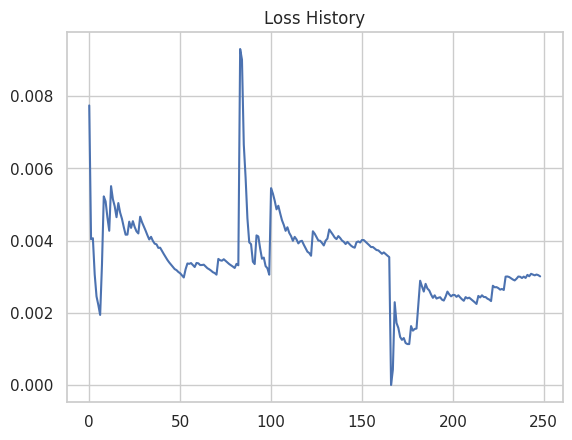

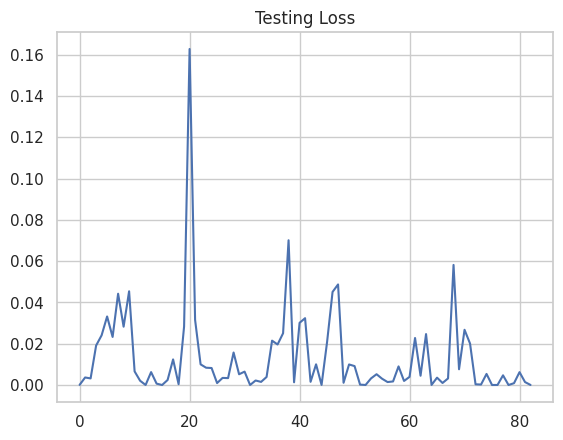

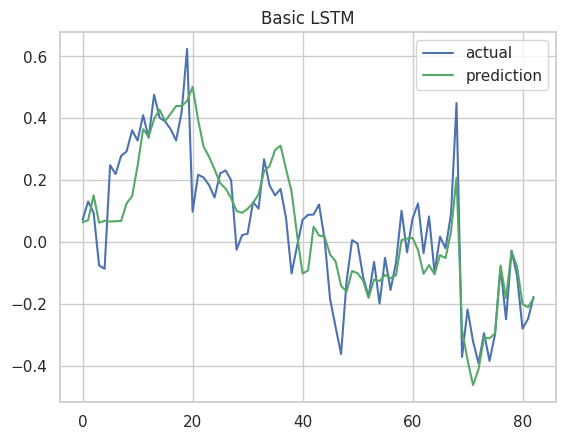

In [235]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1 #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

### Testing the strategy

### Comparing strategies with traditional method

## Conclusion